# Linear Regression

In this notebook we will examine predictive modelling in the form of linear regression. 

First, we need to import a numbner of packages. In Python, the most comprehensive machine learning library is SciKit-Learn. It provides many common machine learning algorithms as well as a large number of utility functions and tools, some of which we will see here.

We will also perform a form of model evaluation known as cross validation.

Let's import SciKit-Learn, which is packaged as `sklearn`, and some dependencies. It is common to use a combination of SciKit-Learn, NumPy, Pandas, and SciPy for machine learning tasks.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.preprocessing import normalize
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Preparing Our Data

In this example, we will analyse a diabetes dataset that is part of the `sklearn.datasets` module:

In [2]:
diabetes = datasets.load_diabetes()

We will also create a Pandas DataFrame version of the dataset, as several tools can work with DataFrames and these are often easier to work with than NumPy data structures:

In [3]:
diabetes_pd = pd.DataFrame(diabetes.data)

Let's examine the top few rows of the data set: 

In [4]:
diabetes_pd.head()

,0,1,2,3,4,5,6,7,8,9
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


As you can see, the DataFrame does not contain any column names, so we currently have no indication as to what each colum represents. 

For more information, the data itself is described here:
<http://www4.stat.ncsu.edu/%7Eboos/var.select/diabetes.html> and the paper regarding the data's analysis can be found here <http://web.stanford.edu/%7Ehastie/Papers/LARS/LeastAngle_2002.pdf>

The paper itself describes a technique called Least Angle Regression (LARS), but in this case we will apply  linear regression with least squares error.

Notice also that the data is the `sklearn.datasets` packages has already been normalised.

From the links above we can find the column names (we will call them the *features*):

In [5]:
feature_names = ["age", "sex", "bmi", "map", "tc", "ldl", "hdl", "tch", "ltg", "glu"]

The variables are age, sex, body mass index, average blood pressure, and six blood serum values.

To give each column a name, we can access the DataFrame's `columns` member variable:

In [6]:
diabetes_pd.columns = feature_names

In [7]:
diabetes_pd.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


You may notice that the `sex` feature contains strange data. We may first want to look at the column's unique values:

In [8]:
diabetes_pd.sex.unique()

array([ 0.05068012, -0.04464164])

You will that the sex of the patient is either `0.0506` or `-0.0446`, in other words either slightly negative or slightly positive. Because it is a categorical value we will drop this column for simplicity. Also we will add a `y` target column for the disease progression. The disease progression is a score that gives a numerical value to the extent at which diabetes has affected the patient. 

In [9]:
diabetes_pd["y"] = diabetes.target

So we have added a new column called `y` that contains the disease progression, we can see how this looks by using `head` or `tail`:

In [10]:
diabetes_pd.tail()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0
441,-0.045472,-0.044642,-0.073030,-0.081414,0.083740,0.027809,0.173816,-0.039493,-0.004220,0.003064,57.0


As an example, we will look to see if there is a correlation between BMI and disease progression. Later we will analyse the entire dataset. Using fewer features makes it easier to visualise and plot results, etc.

Here we take the `bmi` column and store it in a variable `X`:

In [11]:
X = diabetes_pd.bmi

We will then convert this to a NumPy array for use with SciKit-Learn later:

In [12]:
X = np.array(X)

The target, or value we want to predict, will be stored in a variable `y`: 

In [13]:
y = diabetes_pd.y
y = np.array(y)

Finally, we will create restructure the data slightly to make it compatible with SciKit-Learn:

In [14]:
# Resize as they want in new versions of SciKit as per the warning
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

## Splitting Data into a Training Set and a Test Set

Now we have our data in to varibles, where `X` contains the data regarding each patient's BMI and `y` contains the data regarding each patient's disease activity score, we will split the data into what is known as a training set and a test set. 

The training set will be used by our linear regression algorithm to learn a model that predict's the disease progression. Once the model has been trained using the training data, we will use the test set to see how well the trained model fits to **new** data. This is the test set. In this simple example we will select $80$ samples from our total of $n=442$ samples in our test set. The remaining $442-80=362$ samples will be used to train our linear regression model.

In [15]:
X_train = X[:-80]
y_train = y[:-80]

In [16]:
X_test = X[-80:]
y_test = y[-80:]

In [17]:
print("X_train contains %d samples and the y_train contains %d samples" % (len(X_train), len(y_train)))
print("X_test contains %d samples and the y_test contains %d samples" % (len(X_test), len(y_test)))

X_train contains 362 samples and the y_train contains 362 samples
X_test contains 80 samples and the y_test contains 80 samples


## Training a Linear Regression Model

We beging by using the `LinearRegression` class of SciKit-Learn and create an instance of this class:

In [18]:
linear_reg = linear_model.LinearRegression()

Now we fit the model according to the data in the training set. This is a **supervised** algorithm, so the linear model is fitting according to the data contained in `X` and minimising the loss according to `y`: 

In [19]:
linear_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

That's it! The model has been fit, and we should now evaluate it on the test set. This will check how well the model fits to new, unseen data. Remember, the model was fit on the training set alone. It has never seen the data contained in `X_test` or the target data contained in `y_test`.

In [20]:
linear_reg.score(X_test, y_test)

0.36469910696163765

In [21]:
np.mean((linear_reg.predict(X_test) - y_test) ** 2)

3862.9866871598133

## Plotting the Results

We can plot the data in the test set, that is plot the BMI against the disease progression, and then plot the line that the Linear Regression model calculated as being the optimal line through the test data (based on the model learned on the training data): 

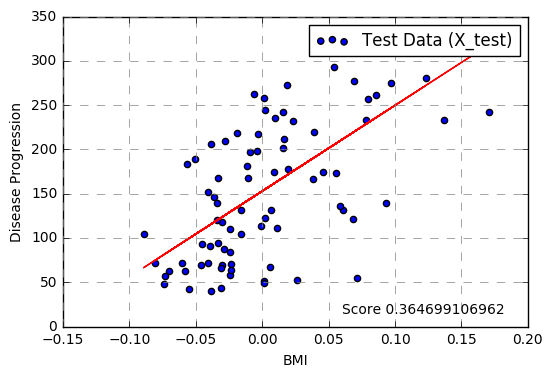

In [22]:
plt.scatter(X_test, y_test, label="Test Data (X_test)")
plt.plot(X_test, linear_reg.predict(X_test), color="red")
plt.xlabel("BMI")
plt.ylabel("Disease Progression")
plt.text(0.06, 15, "Score " + str(linear_reg.score(X_test, y_test)))
plt.grid(color="gray", linestyle='--')
plt.legend()
plt.show();

## Higher-Dimensional Data

You will remember that in the analysis above, we extracted only one feature from the dataset (BMI) and tried to fit a model that would predict the disease progression based on the value of the BMI. We extracted one feature as this makes it easier to plot results. However, generally you would not want to throw away most of your features when working on a dataset. 

In this example we will use all the features of the dataset, and see how to plot the results even if we have higher dimensional data.

First, let's prepare the data for input into SciKit-Learn:

In [23]:
X = diabetes_pd
y = diabetes_pd.y
# Remove the target variable from the training data.
del X["y"]
X = np.array(X)
y = np.array(y)

Create a training set and a test set. We will see later why you would shuffle this data and not simply slice a percentage of the data to create train/test splits:

In [24]:
cut_off = 120
X_train = X[:-cut_off]
y_train = y[:-cut_off]
X_test = X[-cut_off:]
y_test = y[-cut_off:]
print("X_train contains %d samples and the y_train contains %d samples" % (len(X_train), len(y_train)))
print("X_test contains %d samples and the y_test contains %d samples" % (len(X_test), len(y_test)))

X_train contains 322 samples and the y_train contains 322 samples
X_test contains 120 samples and the y_test contains 120 samples


Train a linear regression model on this data, using all features (10 in total):

In [25]:
linear_reg_all = linear_model.LinearRegression()
linear_reg_all.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Once we have trained a model using the training data in `X_train`, we can test it on some unseen data, in this case stored in `X_test`: 

In [26]:
linear_reg_all.score(X_test, y_test)

0.53783452069970394

### Plotting the Results

When you wish to plot the results of a higher dimensional dataset's results, we can plot the measure outcome, stored in `y` against the predicted outcome, i.e. the output of `linear_reg_all.predict(y)` for each $y_i$ in y.

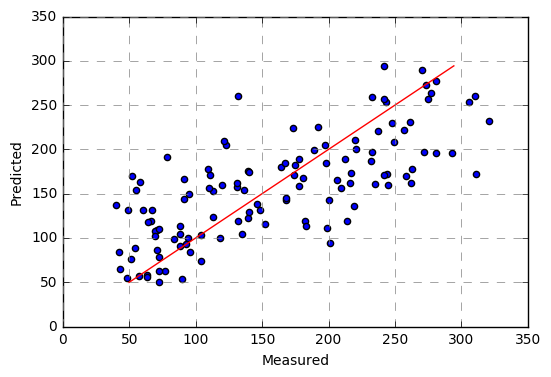

In [27]:
plt.scatter(y_test, linear_reg_all.predict(X_test))
plt.plot([linear_reg_all.predict(X_test).min(), linear_reg_all.predict(X_test).max()], [linear_reg_all.predict(X_test).min(), linear_reg_all.predict(X_test).max()], c='red')
plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.grid(color="gray", linestyle='--')
plt.show();